In [ ]:
import os
import sys

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


from utils.helper import get_root_dir, set_seed, setup_gpu
from utils.data import load_data, load_data_with_test_split
from utils.plots import plot_reconstructions, plot_history
from utils.latent_space import plot_latent_space
from utils.evaluation import evaluate_autoencoder, ssim_loss, ssim_l1_loss, dssim_loss, evaluate_autoencoder_with_distribution_threshold, evaluate_autoencoder_with_threshold_generator, predict_anomaly_and_plot

In [2]:
# Hyperparameter to tune
config = {
    "comment": "deep autoencoder",
    "epochs": 100,
    "loss": "ssim_l1",
    "optimizer": "adam",
    "dropout_value": 0.3,
    "batch_norm": True,
    "batch_size": 16,
    "latent_dim": 512,
    "threshold_percentage": 80,
    "data_class": "screw",
    "model_type": "autoencoder",
}

# Rather static parameters, no need to track
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [3]:
wandb.init(project="itu-aml-project", config=config)
config = (
    wandb.config
)  # this turns our hyperparameter config into a proper object with attributes

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jonathantiedchen (itu-aml-project). Use `wandb login --relogin` to force relogin


In [4]:
# root_dir = get_root_dir()
root_dir = "Mini Project"
setup_gpu()
set_seed(1234)

model_dir = os.path.join(root_dir, "models", config.model_type)

cpkt_path = os.path.join(
    model_dir, "logs", "checkpoints", f"{config.comment}_checkpoint.model.keras"
)
weights_path = os.path.join(
    model_dir, "logs", "weights", f"{config.comment}_model.keras"
)
assert not os.path.exists(
    weights_path
), f"Path already exists: {weights_path}. Please change the comment."

No GPU found, using CPU.


In [5]:
train_generator, validation_generator, test_generator, threshold_generator = (
    load_data_with_test_split(category="screw", batch_size=32, test_split=0.4)
)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 98 images belonging to 6 classes.
Found 62 images belonging to 6 classes.


In [6]:
# https://github.com/plutoyuxie/AutoEncoder-SSIM-for-unsupervised-anomaly-detection-/blob/master/train.py
def deep_autoencoder(
    input_shape=(256, 256, 3),
    optimizer="adam",
    latent_dim=512,
    loss="mse",
    batch_norm=True,
    dropout_value=0.5,
):

    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding="same")(
        input_img
    )
    if batch_norm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(32, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    if batch_norm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(32, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    if batch_norm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(64, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    if batch_norm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(64, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    if batch_norm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(128, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    if batch_norm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(64, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    if batch_norm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(32, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    if batch_norm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    encoded = Conv2D(
        latent_dim, (8, 8), strides=1, activation="linear", padding="valid"
    )(x)

    # Decoder
    x = Conv2DTranspose(
        32, (8, 8), strides=1, activation=LeakyReLU(alpha=0.2), padding="valid"
    )(encoded)
    x = Conv2D(64, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    x = Conv2D(128, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    x = Conv2DTranspose(
        64, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding="same"
    )(x)
    x = Conv2D(64, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    x = Conv2DTranspose(
        32, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding="same"
    )(x)
    x = Conv2D(32, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(
        x
    )
    x = Conv2DTranspose(
        32, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding="same"
    )(x)
    decoded = Conv2DTranspose(
        input_shape[2], (4, 4), strides=2, activation="sigmoid", padding="same"
    )(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    return autoencoder


# get correct loss from config as functions are not callable from config itself
if config.loss == "mae":
    loss = "mae"
elif config.loss == "mse":
    loss = "mse"
elif config.loss == "dssim":
    loss = dssim_loss
elif config.loss == "ssim":
    loss = ssim_loss
elif config.loss == "ssim_l1":
    loss = ssim_l1_loss
else:
    raise ValueError(
        f"Unknown loss function: {config.loss}. Please define a function to calculate the error."
    )

autoencoder = deep_autoencoder(
    input_shape=INPUT_SHAPE,
    optimizer=config.optimizer,
    latent_dim=config.latent_dim,
    loss=loss,
    batch_norm=config.batch_norm,
    dropout_value=0.3,
)

print("Input shape:", autoencoder.input_shape)
print("Output shape:", autoencoder.output_shape)

autoencoder.summary()

Input shape: (None, 256, 256, 3)
Output shape: (None, 256, 256, 3)


/opt/conda/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,740,355 (10.45 MB)

 Trainable params: 2,739,459 (10.45 MB)

 Non-trainable params: 896 (3.50 KB)

In [7]:
# define early stopping and checkpoints
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", patience=30, start_from_epoch=20
)

checkpoint = ModelCheckpoint(
    cpkt_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1
)

history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[
        early_stop,
        checkpoint,
        WandbMetricsLogger(),
        # WandbModelCheckpoint("models"), # Saves model checkpoint to W&B
    ],
)

wandb.finish()

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 0.2511
Epoch 1: val_loss improved from inf to 0.24859, saving model to Mini Project/models/autoencoder/logs/checkpoints/deep autoencoder_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 671ms/step - loss: 0.2509 - val_loss: 0.2486
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 0.2469
Epoch 2: val_loss improved from 0.24859 to 0.24130, saving model to Mini Project/models/autoencoder/logs/checkpoints/deep autoencoder_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 531ms/step - loss: 0.2463 - val_loss: 0.2413
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 0.1970
Epoch 3: val_loss improved from 0.24130 to 0.22066, saving model to Mini Project/models/autoencoder/logs/checkpoints/deep autoencoder_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 534ms/step - loss: 0.1955 - val_loss: 0.2207
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 0.1469
Epoch 4: val_loss improved from 0.22066 to 0.1946

epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁
epoch/val_loss,██▆▆▆▆▆▅▅▅▅▅▄▅▅▄▄▄▃▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▂▂
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.06318
epoch/val_loss,0.08012


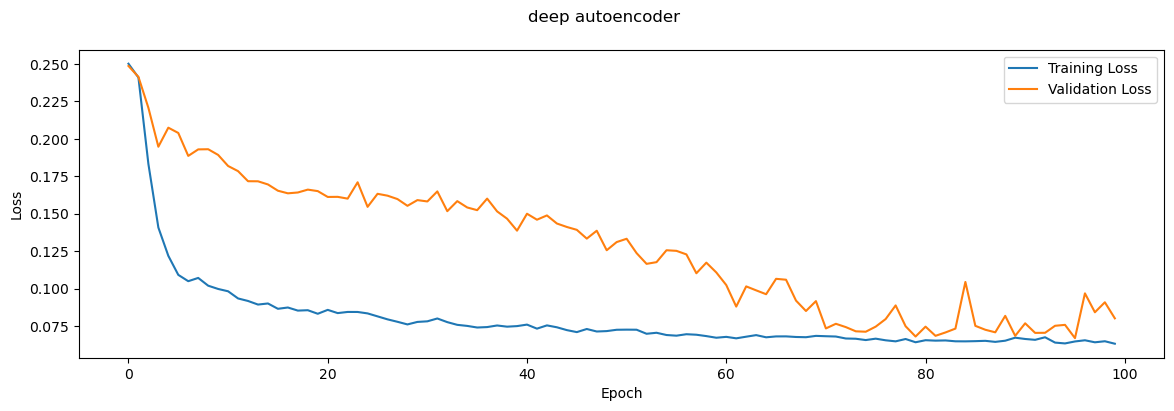

Best train_loss: 0.0632
Best val_loss: 0.0669
Last improvement of val_loss at epoch: 1


In [8]:
# plot the training history
plot_history(comment=config.comment, history=history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


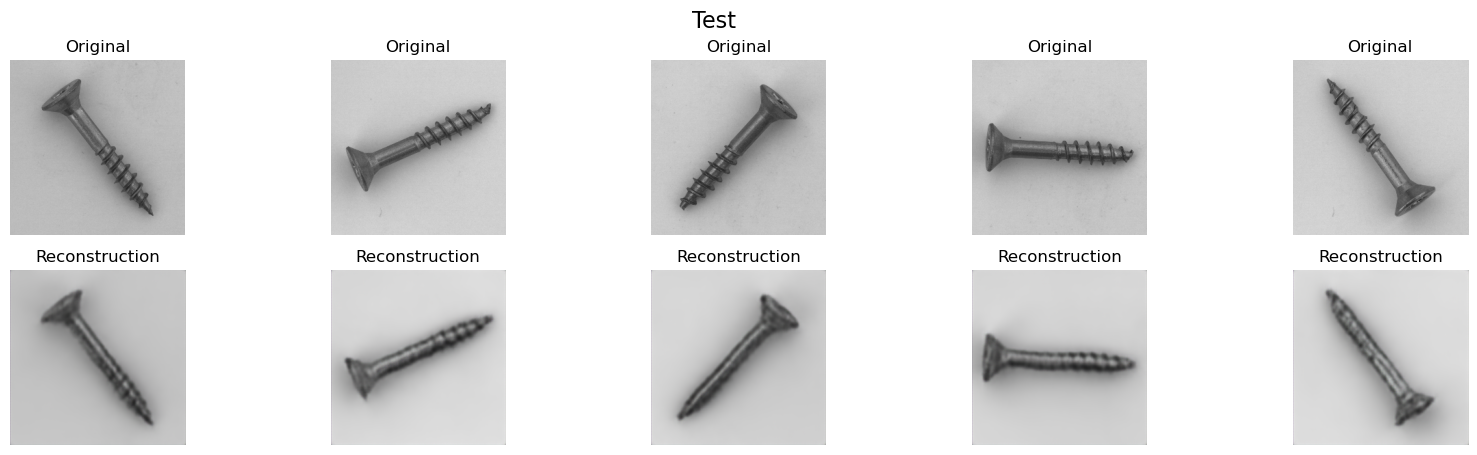

In [9]:
plot_reconstructions(autoencoder, test_generator, n_images=5, title="Test")

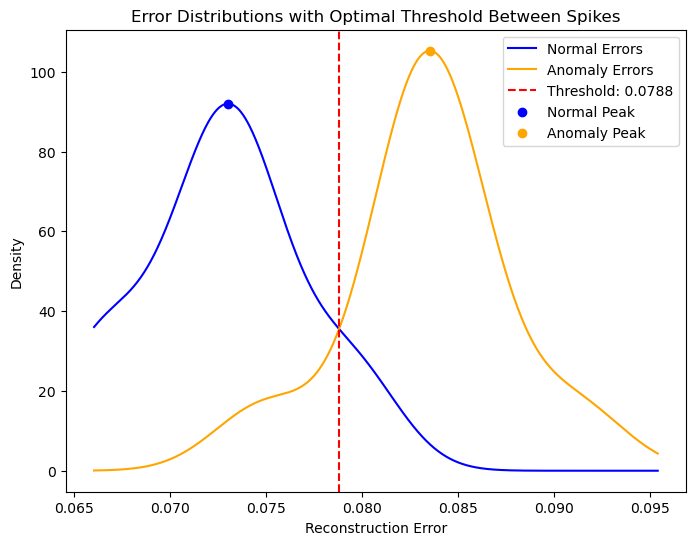

Optimal Threshold: 0.0788
              precision    recall  f1-score   support

      Normal       0.58      0.84      0.69        25
     Anomaly       0.94      0.79      0.86        73

    accuracy                           0.81        98
   macro avg       0.76      0.82      0.77        98
weighted avg       0.85      0.81      0.82        98



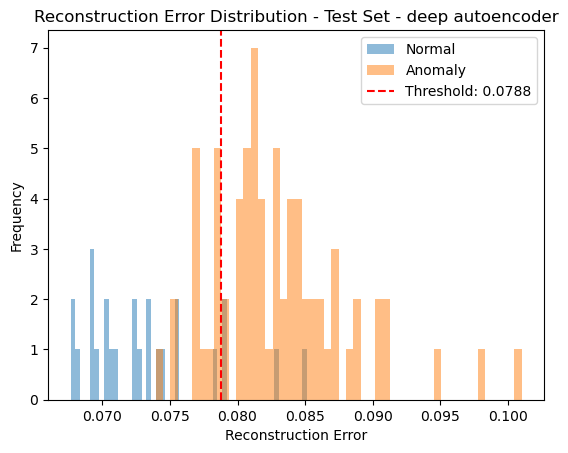

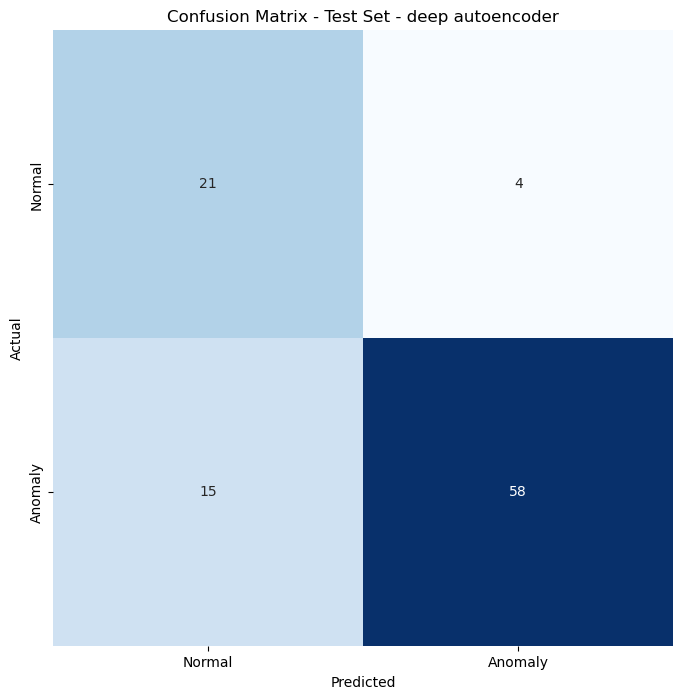

In [10]:
# sampling generated from flow
evaluate_autoencoder_with_threshold_generator(
    autoencoder=autoencoder,
    test_generator=test_generator,
    threshold_generator=threshold_generator,
    config=config,
)

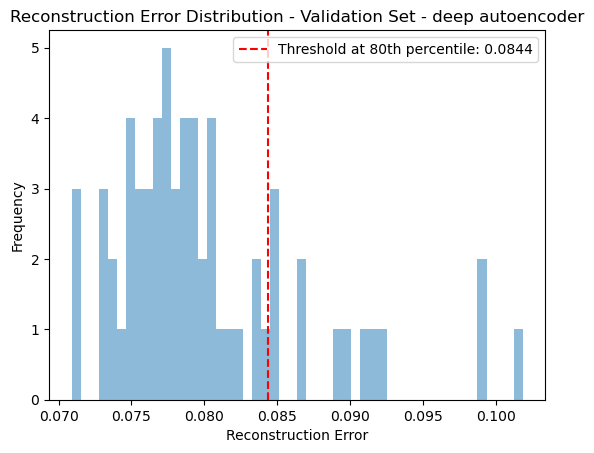

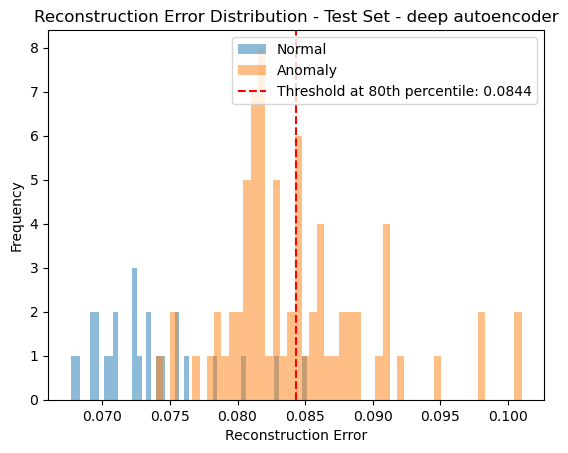

              precision    recall  f1-score   support

      Normal       0.36      0.96      0.52        25
     Anomaly       0.97      0.41      0.58        73

    accuracy                           0.55        98
   macro avg       0.66      0.69      0.55        98
weighted avg       0.81      0.55      0.56        98



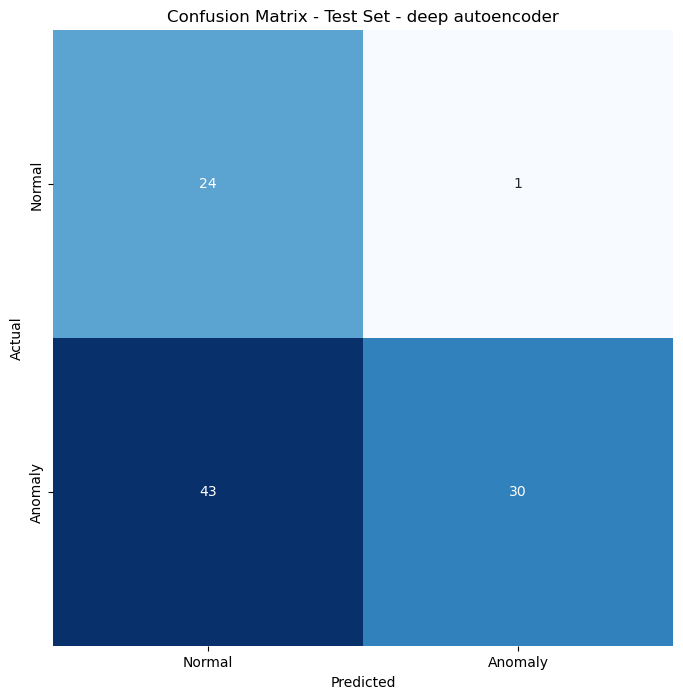

In [11]:
evaluate_autoencoder(
    config=config,
    autoencoder=autoencoder,
    validation_generator=validation_generator,
    test_generator=test_generator,
)

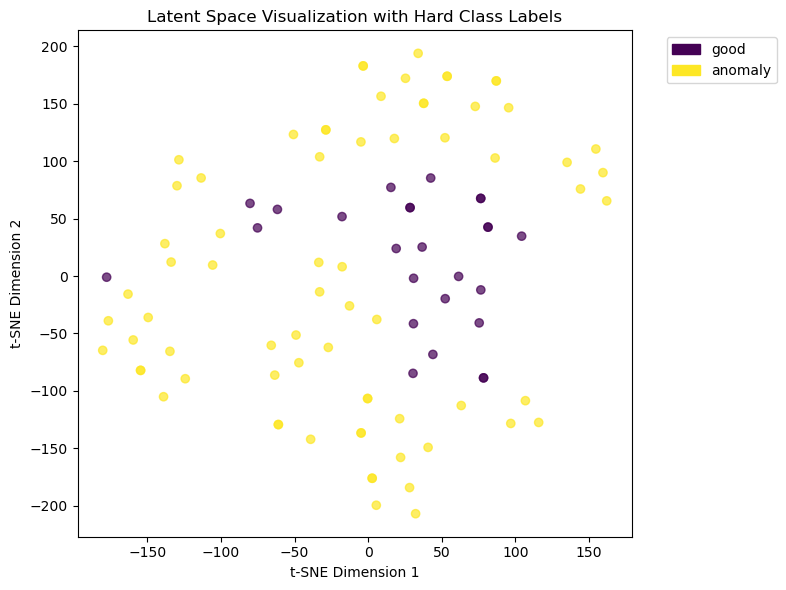

In [15]:
plot_latent_space(autoencoder, test_generator, layer_name="conv2d_8")

The file exists: ../../data/screw/test/manipulated_front/001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


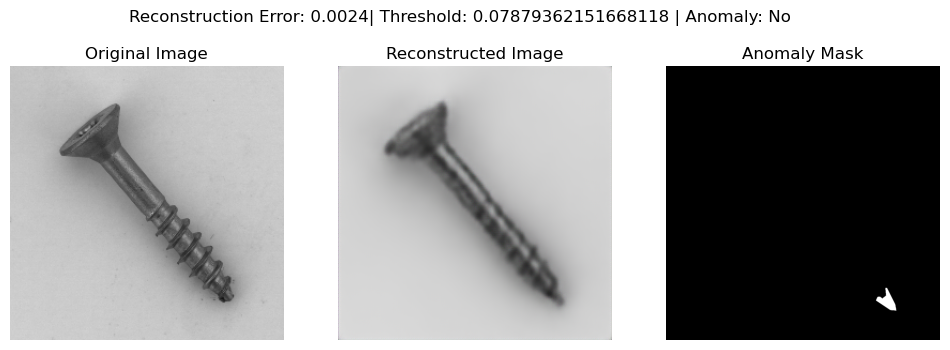

The file exists: ../../data/screw/test/scratch_head/001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


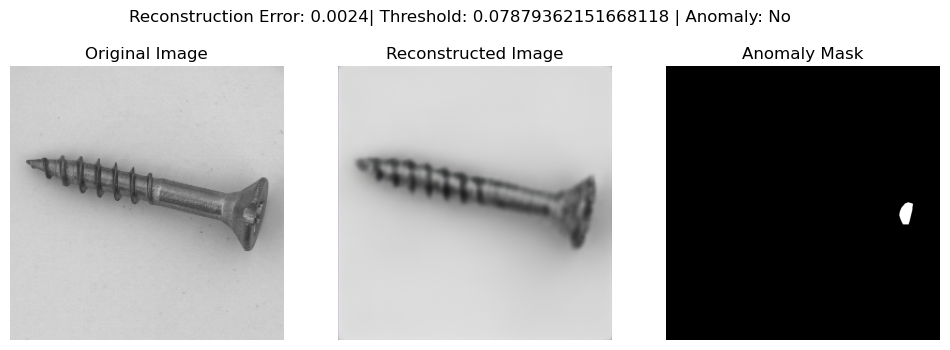

The file exists: ../../data/screw/test/scratch_neck/001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


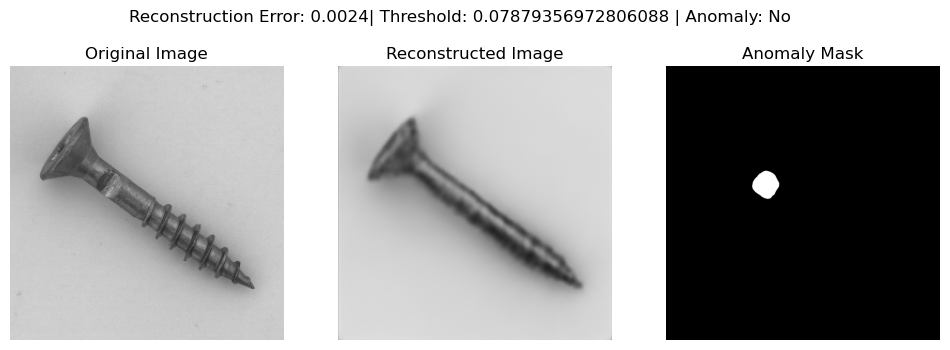

In [13]:
mask_dir = '../../data/screw/ground_truth'
image_paths = [
    '../../data/screw/test/manipulated_front/001.png',
    '../../data/screw/test/scratch_head/001.png', 
    '../../data/screw/test/scratch_neck/001.png' 
]
for path in image_paths:
    predict_anomaly_and_plot(
    autoencoder=autoencoder,
    threshold_generator=threshold_generator,  # Now this works
    mask_dir=mask_dir,
    image_path=path,
    loss_function=config.loss,
    threshold=0.2
)